In [1]:
import os
import sys

sys.path.append("/mnt/workdata/_WORK_/mail_zonning/mail_zoning/classes")

import datetime as dt
os.environ['CUDA_VISIBLE_DEVICES'] = ""
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import mlflow
import json
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import itertools
from tqdm import tqdm
import inspect
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_classifier import MovingWindowSentenceClassifier

for m in [pd, tf, tfa, mlflow]:
    print(f"{m.__name__:20s}\t{m.__version__}")

tf.config.experimental.enable_tensor_float_32_execution(enabled=True)

DATAPATH = "/mnt/workdata/_WORK_/mail_zonning/mail_zoning/dataset/enron_files_annotated/"

/home/mchomicz/envs/env_py38_tf29/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pandas              	1.5.0
tensorflow          	2.9.2
tensorflow_addons   	0.18.0
mlflow              	1.29.0


In [2]:
start=dt.datetime.now()

# Supporting methods

In [3]:
def prepare_dataset(datapath: str):
    def extract_text(text, flags: dict):
        text = text.split('\n')
        idx = 0
        while text[idx][:2] not in flags:
            idx += 1
        labels = [flags[t[:2]] for t in text[idx:] if len(t) > 1]
        text = [t[2:] for t in text[idx:]]
        return text, labels

    # load and extract flag data
    FLAGS = {'B>': 0, 'H>': 1, 'S>': 2}
    files = {}
    for filename in os.listdir(datapath):
        with open(os.path.join(datapath, filename), 'rt') as f:
            files[filename] = f.read()
    _ = []
    for filename in files.keys():
        text_ = files[filename]
        textlines, labels = extract_text(text_, FLAGS)
        for idx, line_label in enumerate(zip(textlines, labels)):
            _.append({'doc': filename, 'idx': idx, 'sentence': line_label[0], 'label': line_label[1]})
    df = pd.DataFrame.from_dict(_)
    return df

def split_dataset(data: pd.DataFrame, random_state: int):
    """"
    Dataset split is based on complete emails, not on email lines
    """
    splitter = KFold(n_splits=5, shuffle=True, random_state=random_state)
    docs = data['doc'].unique()
    splits = splitter.split(docs)
    train_data = []
    val_data = []
    for train_idx, val_idx in splits:
        train_data_ = data.loc[data['doc'].isin(docs[train_idx])]
        train_data.append(train_data_[['doc', 'idx', 'sentence', 'label']])
        val_data_ = data.loc[data['doc'].isin(docs[val_idx])]
        val_data.append(val_data_[['doc', 'idx', 'sentence', 'label']])
    return train_data, val_data

## Window size = 3

In [4]:
model_params = {
    "output_class_count": 3,
    "vocab_size": 8000,
    "output_sequence_length": 45,
    "embedding_dimension": 150,
    "window_size": 3,
    "conv1d_0_units": 80,
    "conv1d_0_kernelsize": 3,
    "conv1d_0_padding": "valid",
    "conv1d_0_activation": "relu",
    "conv1d_1_units": 80,
    "conv1d_1_kernelsize": 3,
    "conv1d_1_padding": "valid",
    "conv1d_1_activation": "relu",
    "gru_0_units": 128,
    "gru_1_units": 64,
    "drop_0_rate": 0.3448836829019953,
    "initial_lr": 0.0006500000000000001,
    "lr_reduction_factor": 0.44531593652922397,
    "lr_reduction_patience": 3,
    "batch_size": 56,
    "max_epochs": 100,
    "early_stop_patience": 10
}
RANDOM_STATE=123
df = prepare_dataset(DATAPATH)
train_subsets, val_subsets = split_dataset(df, RANDOM_STATE)

texts = df['sentence'].values
results={}
for idx in range(len(train_subsets)):
    print(f"Subset: {idx}, train records: {train_subsets[idx].shape[0]}, validation: {val_subsets[idx].shape[0]}")
    print(f"Liczba wspólnych dla train i val: {len(set(train_subsets[idx]['doc']).intersection(set(val_subsets[idx]['doc'])))}")
    tf.keras.backend.clear_session()
    clf=MovingWindowSentenceClassifier(
        model_params=model_params,
        bod_line = 'This is the first line of document. No lines come before.',
        eod_line='This is the last line of document. No lines come after.',
        corpus=texts)
    clf.prepare_train_records(data=train_subsets[idx])
    clf.prepare_validation_records(data=val_subsets[idx])
    clf.compile(optimizer=tf.keras.optimizers.Adam(model_params['initial_lr']),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    clf.fit(
            x=clf.train_texts, y=clf.train_labels,
            batch_size=model_params['batch_size'],
            epochs=model_params['max_epochs'],
            validation_data=(clf.validation_texts, clf.validation_labels),
            use_multiprocessing=True,
            callbacks=[
                tf.keras.callbacks.ReduceLROnPlateau(
                    factor=model_params['lr_reduction_factor'], patience=model_params['lr_reduction_patience'], verbose=0),
                tf.keras.callbacks.EarlyStopping(
                    min_delta=1e-4, patience=model_params['early_stop_patience'], restore_best_weights=True)
            ],verbose=1)
    results[idx]=clf.evaluate(clf.validation_texts, clf.validation_labels)

master_results={3:results}

Subset: 0, train records: 5684, validation: 1191
Liczba wspólnych dla train i val: 0


2022-12-27 19:47:27.061170: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-27 19:47:27.061209: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mchubuntu.mch.net.pl
2022-12-27 19:47:27.061218: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mchubuntu.mch.net.pl
2022-12-27 19:47:27.061390: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-12-27 19:47:27.061415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-12-27 19:47:27.061422: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-12-27 19:47:27.061676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the follow

Epoch 1/100
102/102 [==============================] - 7s 35ms/step - loss: 0.4012 - accuracy: 0.8513 - val_loss: 0.6425 - val_accuracy: 0.7741 - lr: 6.5000e-04
Epoch 2/100
102/102 [==============================] - 3s 27ms/step - loss: 0.0993 - accuracy: 0.9659 - val_loss: 0.4616 - val_accuracy: 0.8312 - lr: 6.5000e-04
Epoch 3/100
102/102 [==============================] - 3s 27ms/step - loss: 0.0616 - accuracy: 0.9819 - val_loss: 0.3422 - val_accuracy: 0.8556 - lr: 6.5000e-04
Epoch 4/100
102/102 [==============================] - 3s 27ms/step - loss: 0.0421 - accuracy: 0.9879 - val_loss: 0.1968 - val_accuracy: 0.9379 - lr: 6.5000e-04
Epoch 5/100
102/102 [==============================] - 3s 27ms/step - loss: 0.0377 - accuracy: 0.9894 - val_loss: 0.1675 - val_accuracy: 0.9479 - lr: 6.5000e-04
Epoch 6/100
102/102 [==============================] - 3s 27ms/step - loss: 0.0329 - accuracy: 0.9900 - val_loss: 0.1942 - val_accuracy: 0.9404 - lr: 6.5000e-04
Epoch 7/100
102/102 [=============

## Window size = 5

In [5]:
model_params = {
    "output_class_count": 3,
    "vocab_size": 8000,
    "output_sequence_length": 45,
    "embedding_dimension": 150,
    "window_size": 5,
    "conv1d_0_units": 80,
    "conv1d_0_kernelsize": 3,
    "conv1d_0_padding": "valid",
    "conv1d_0_activation": "relu",
    "conv1d_1_units": 80,
    "conv1d_1_kernelsize": 3,
    "conv1d_1_padding": "valid",
    "conv1d_1_activation": "relu",
    "gru_0_units": 128,
    "gru_1_units": 64,
    "drop_0_rate": 0.3448836829019953,
    "initial_lr": 0.0006500000000000001,
    "lr_reduction_factor": 0.44531593652922397,
    "lr_reduction_patience": 3,
    "batch_size": 56,
    "max_epochs": 100,
    "early_stop_patience": 10
}
RANDOM_STATE=123
df = prepare_dataset(DATAPATH)
train_subsets, val_subsets = split_dataset(df, RANDOM_STATE)

texts = df['sentence'].values
results={}
for idx in range(len(train_subsets)):
    print(f"Subset: {idx}, train records: {train_subsets[idx].shape[0]}, validation: {val_subsets[idx].shape[0]}")
    print(f"Liczba wspólnych dla train i val: {len(set(train_subsets[idx]['doc']).intersection(set(val_subsets[idx]['doc'])))}")
    tf.keras.backend.clear_session()
    clf=MovingWindowSentenceClassifier(
        model_params=model_params,
        bod_line = 'This is the first line of document. No lines come before.',
        eod_line='This is the last line of document. No lines come after.',
        corpus=texts)
    clf.prepare_train_records(data=train_subsets[idx])
    clf.prepare_validation_records(data=val_subsets[idx])
    clf.compile(optimizer=tf.keras.optimizers.Adam(model_params['initial_lr']),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    clf.fit(
            x=clf.train_texts, y=clf.train_labels,
            batch_size=model_params['batch_size'],
            epochs=model_params['max_epochs'],
            validation_data=(clf.validation_texts, clf.validation_labels),
            use_multiprocessing=True,
            callbacks=[
                tf.keras.callbacks.ReduceLROnPlateau(
                    factor=model_params['lr_reduction_factor'], patience=model_params['lr_reduction_patience'], verbose=0),
                tf.keras.callbacks.EarlyStopping(
                    min_delta=1e-4, patience=model_params['early_stop_patience'], restore_best_weights=True)
            ],verbose=1)
    results[idx]=clf.evaluate(clf.validation_texts, clf.validation_labels)

master_results[5]=results

Subset: 0, train records: 5684, validation: 1191
Liczba wspólnych dla train i val: 0
Epoch 1/100
102/102 [==============================] - 8s 46ms/step - loss: 0.3460 - accuracy: 0.8696 - val_loss: 0.6810 - val_accuracy: 0.7741 - lr: 6.5000e-04
Epoch 2/100
102/102 [==============================] - 4s 38ms/step - loss: 0.0769 - accuracy: 0.9719 - val_loss: 0.4708 - val_accuracy: 0.7851 - lr: 6.5000e-04
Epoch 3/100
102/102 [==============================] - 4s 38ms/step - loss: 0.0404 - accuracy: 0.9872 - val_loss: 0.3473 - val_accuracy: 0.8371 - lr: 6.5000e-04
Epoch 4/100
102/102 [==============================] - 4s 38ms/step - loss: 0.0261 - accuracy: 0.9931 - val_loss: 0.2081 - val_accuracy: 0.9110 - lr: 6.5000e-04
Epoch 5/100
102/102 [==============================] - 4s 37ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.2180 - val_accuracy: 0.9270 - lr: 6.5000e-04
Epoch 6/100
102/102 [==============================] - 4s 38ms/step - loss: 0.0211 - accuracy: 0.9928 - val_lo

## Window size = 7

In [6]:
model_params = {
    "output_class_count": 3,
    "vocab_size": 8000,
    "output_sequence_length": 45,
    "embedding_dimension": 150,
    "window_size": 7,
    "conv1d_0_units": 80,
    "conv1d_0_kernelsize": 3,
    "conv1d_0_padding": "valid",
    "conv1d_0_activation": "relu",
    "conv1d_1_units": 80,
    "conv1d_1_kernelsize": 3,
    "conv1d_1_padding": "valid",
    "conv1d_1_activation": "relu",
    "gru_0_units": 128,
    "gru_1_units": 64,
    "drop_0_rate": 0.3448836829019953,
    "initial_lr": 0.0006500000000000001,
    "lr_reduction_factor": 0.44531593652922397,
    "lr_reduction_patience": 3,
    "batch_size": 56,
    "max_epochs": 100,
    "early_stop_patience": 10
}
RANDOM_STATE=123
df = prepare_dataset(DATAPATH)
train_subsets, val_subsets = split_dataset(df, RANDOM_STATE)

texts = df['sentence'].values
results={}
for idx in range(len(train_subsets)):
    print(f"Subset: {idx}, train records: {train_subsets[idx].shape[0]}, validation: {val_subsets[idx].shape[0]}")
    print(f"Liczba wspólnych dla train i val: {len(set(train_subsets[idx]['doc']).intersection(set(val_subsets[idx]['doc'])))}")
    tf.keras.backend.clear_session()
    clf=MovingWindowSentenceClassifier(
        model_params=model_params,
        bod_line = 'This is the first line of document. No lines come before.',
        eod_line='This is the last line of document. No lines come after.',
        corpus=texts)
    clf.prepare_train_records(data=train_subsets[idx])
    clf.prepare_validation_records(data=val_subsets[idx])
    clf.compile(optimizer=tf.keras.optimizers.Adam(model_params['initial_lr']),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    clf.fit(
            x=clf.train_texts, y=clf.train_labels,
            batch_size=model_params['batch_size'],
            epochs=model_params['max_epochs'],
            validation_data=(clf.validation_texts, clf.validation_labels),
            use_multiprocessing=True,
            callbacks=[
                tf.keras.callbacks.ReduceLROnPlateau(
                    factor=model_params['lr_reduction_factor'], patience=model_params['lr_reduction_patience'], verbose=0),
                tf.keras.callbacks.EarlyStopping(
                    min_delta=1e-4, patience=model_params['early_stop_patience'], restore_best_weights=True)
            ],verbose=1)
    results[idx]=clf.evaluate(clf.validation_texts, clf.validation_labels)

master_results[7]=results

Subset: 0, train records: 5684, validation: 1191
Liczba wspólnych dla train i val: 0
Epoch 1/100
102/102 [==============================] - 9s 55ms/step - loss: 0.3592 - accuracy: 0.8587 - val_loss: 0.6745 - val_accuracy: 0.7741 - lr: 6.5000e-04
Epoch 2/100
102/102 [==============================] - 5s 48ms/step - loss: 0.0735 - accuracy: 0.9701 - val_loss: 0.5255 - val_accuracy: 0.7741 - lr: 6.5000e-04
Epoch 3/100
102/102 [==============================] - 5s 48ms/step - loss: 0.0398 - accuracy: 0.9863 - val_loss: 0.3552 - val_accuracy: 0.8455 - lr: 6.5000e-04
Epoch 4/100
102/102 [==============================] - 5s 48ms/step - loss: 0.0191 - accuracy: 0.9942 - val_loss: 0.4207 - val_accuracy: 0.8665 - lr: 6.5000e-04
Epoch 5/100
102/102 [==============================] - 5s 48ms/step - loss: 0.0149 - accuracy: 0.9956 - val_loss: 0.1859 - val_accuracy: 0.9454 - lr: 6.5000e-04
Epoch 6/100
102/102 [==============================] - 5s 48ms/step - loss: 0.0134 - accuracy: 0.9958 - val_lo

# Results comparison

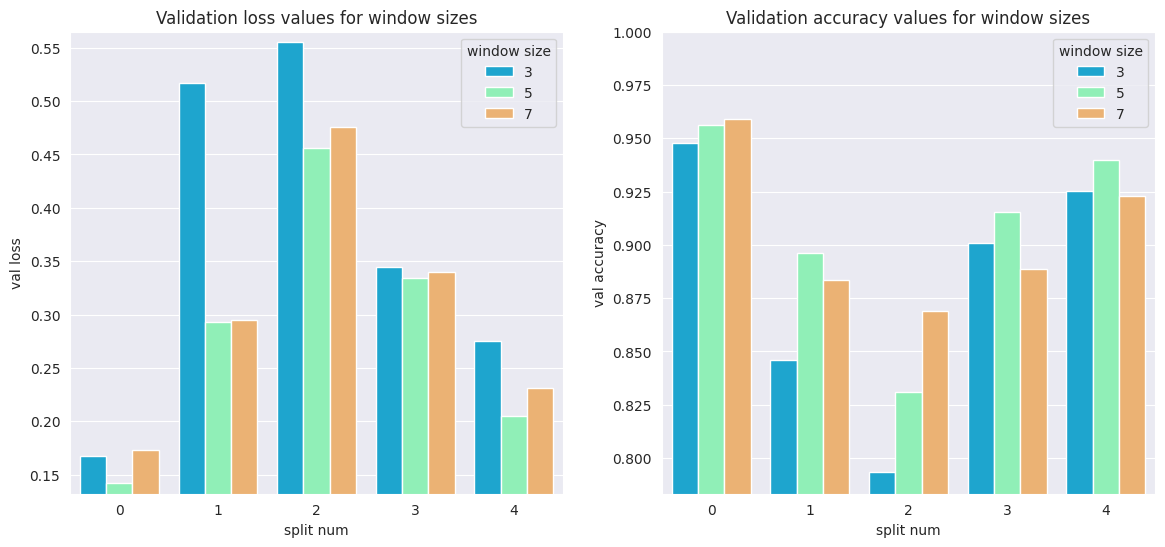

In [7]:
_={(k,s): {'val_loss':master_results[k][s][0], 'val_accuracy': master_results[k][s][1]}
 for k in master_results.keys() for s in master_results[k].keys()}
_ = pd.DataFrame.from_dict(_).T.reset_index()
_.columns=['window size','split num', 'val loss', 'val accuracy']

fig, ax=plt.subplots(1,2,figsize=(14,6))
sns.barplot(data=_, x= 'split num', y='val loss', hue='window size',palette='rainbow', ax=ax[0])
ax[0].set_title("Validation loss values for window sizes")
ax[0].set_ylim(_['val loss'].min()-0.01, _['val loss'].max()+0.01)
sns.barplot(data=_, x= 'split num', y='val accuracy', hue='window size',palette='rainbow', ax=ax[1])
ax[1].set_title("Validation accuracy values for window sizes")
ax[1].set_ylim(_['val accuracy'].min()-0.01, 1.0);

In [8]:
print(f"Total execution time: {dt.datetime.now()-start}")

Total execution time: 0:14:59.900248
